# Generating Image Alt Tags with SceneXplain's API

In this notebook we will see how to use [SceneXplain](https://scenex.jina.ai) to automatically generate alt text for multiple images. This notebook is a companion to the [blog post]() on the same subject.

You will need to sign up for a free SceneXplain account and generate an API key before proceeding.

This notebook consists of several sections:
- **Set options**: Set some basic configuration.
- **Download sample images**: Get sample product images to work with.
- **Break images into batches**: Batch the images for bulk processing.
- **Prepare batches for SceneXplain**: Create the correct data structure for processing.
- **Set up authentication**: Bundle authentication key with image data.
- **Send batches to SceneXplain**: Send the images for processing.
- **Create CSV file with alt texts**: Convert the output into a usable CSV file.

**To run this notebook**, set your options below, then click *Runtime* -> *Run all*.

## Set options

First, let's set up some options:

- **`MAX_IMAGES`**: Maximum number of images to process. Set to -1 for infinite.
- **`BATCH_SIZE`**: Maximum images per batch. Varies depending on your SceneXplain plan. Basic plan is `8`.
- **`CSV_FILENAME`**: Filename for your CSV file that contains filenames and alt texts.
- **`SCENEX_KEY`**: Go to SceneXplain's [API page](https://scenex.jina.ai/api) to generate a unique key to access the API, then paste it where it says "`YOUR KEY`" below. Ensure the quote marks aren't deleted!

In [ ]:
MAX_IMAGES = 32
BATCH_SIZE = 8
CSV_FILENAME = "alt-texts.csv"
SCENEX_KEY = "<YOUR KEY">

## Download sample images

Our example dataset comprises of a subset of 1,000 images from the [Product Data (small) dataset](https://www.kaggle.com/paramaggarwal/fashion-product-images-small) from Kaggle. We've hosted it on Firebase to make it easy to download.

Here's an idea of how the images look:

![](https://storage.googleapis.com/kaggle-datasets-images/175990/396802/720cd7ceb25eb130d0b873464f734370/dataset-cover.png?t=2019-04-26-16-40-29)

In [ ]:
# use wget to download the dataset
!wget -O images.zip "https://firebasestorage.googleapis.com/v0/b/causal-diffusion.appspot.com/o/public%2Ftutorials%2Fscenexplain_alt_text_images.zip?alt=media&token=4937b762-7c8d-4c83-9121-4549d4bad8b7"

In [ ]:
# extract the dataset
!unzip -q images.zip

## Break images into batches

Since we have a lot of images we'll need to split them into batches, since SceneXplain can only handle so many images at once. The maximum batch size depends on your [plan](https://scenex.jina.ai/billing).

In [ ]:
import os

# create a list of image filenames, capped at the maximum number of images you specified
images = os.listdir('./images')[:MAX_IMAGES]

In [ ]:
# break filename list into batches of your chosen size
batches = []

for start in range(0, len(images), BATCH_SIZE):
    end = start + BATCH_SIZE
    batch = images[start:end]
    batches.append(batch)

## Prepare batches for SceneXplain

We can't just send the image filenames to SceneXplain's API. We also need to:

- Convert the image to a format the API can understand (in this case, a base64 datauri).
- Add the name of the task we want to perform on each image.

To do this, we'll write a short function that we can use when we loop through each batch.

In [ ]:
import base64

# Convert image to base64 datauri
def image_to_data_uri(file_path):
    with open(file_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
        return f"data:image/png;base64,{encoded_image}"

In [ ]:
# Populate batch with task data and base64 datauri
def create_data_structure(image_list):
  data = []
  for image_file in image_list:
    data_row = {
        "image": image_to_data_uri(f"images/{image_file}"),
        "task_id": "alt_text",
        "features": ["opt_out"],  # so we don't pollute our SceneXplain history in the UI
        "cid": image_file,
    }
    data.append(data_row)

  return data

In the code above, each image has several fields:

- **`image`**: The image file converted to a [datauri](https://en.wikipedia.org/wiki/Data_URI_scheme).
- **`task_id`**: The task we want to perform. In our case, that's `alt_text`.
- **`features`**: A list of features we want to use. We'll just use `opt_out` so you don't see all these images in your SceneXplain history later.
- **`cid`**: A unique identifier for each image. Since we want to keep the filename linked to the alt text, we'll use the image's filename as the identifier.

## Set up authentication


In [ ]:
headers = {
    "x-api-key": f"token {SCENEX_KEY}",
    "content-type": "application/json",
}

## Send batches to SceneXplain

This code is adapted from [SceneXplain's basic API code](https://scenex.jina.ai/api). This code will take a while to run since it's where the real "work" (generating the alt texts) happens.

In [ ]:
import requests
import json

def send_data(batch):

  data = {
        "data": create_data_structure(batch)
    }

  response = requests.post("https://api.scenex.jina.ai/v1/describe", headers=headers, json=data)

  return response.json()

In [ ]:
all_rows = []

# this part will take a while!
for i, batch in enumerate(batches):
  print(f"Processing batch {i+1}/{len(batches)}")
  response = send_data(batch)
  all_rows.extend(response['result'])

## Create CSV file with alt texts

Now that we've got our image alt texts, let's write them to a CSV file along with the image filename. To do this we'll use Python's built-in [`csv`](https://docs.python.org/3/library/csv.html) library.

In [ ]:
alt_texts = []

In [ ]:
for row in all_rows:
  try:
    alt_texts.append(
        {"filename": row["cid"], "alt-text": row["text"]}
    )
  except:
    # sometimes there may be an invalid output. We use this to skip that otherwise it will stop the whole process.
    pass

In [ ]:
import csv

with open(CSV_FILENAME, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=alt_texts[0].keys())
    writer.writeheader()
    writer.writerows(alt_texts)

You can now double click the csv file in the sidebar to open it, or right-click it to download.

If you can't see the sidebar, click this icon on the left side of your screen to show it:

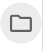

## Preview alt texts

Using Linux's built-in `head` command, we can see some of the alt-tags that were generated.

In [ ]:
PREVIEW_COUNT = 5
!head -n {PREVIEW_COUNT} {CSV_FILENAME}